Блок предобработки временного ряда

Свойства временных рядов

In [77]:
import pandas as pd
df = pd.read_csv('data\climate.csv')
df['Date'] = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')
selected_columns = ['Date', 'p (mbar)', 'Tpot (K)', 'VPdef (mbar)']
df = df[selected_columns]
df = df[:15000]
df.dtypes
df.corr()

,Date,p (mbar),Tpot (K),VPdef (mbar)
Date,1.000000,-0.041085,0.731123,0.519053
p (mbar),-0.041085,1.000000,-0.369578,-0.031343
Tpot (K),0.731123,-0.369578,1.000000,0.723155
VPdef (mbar),0.519053,-0.031343,0.723155,1.000000


In [78]:
# Анализ на наличие пропущенных значений
missing_values = df.isnull().sum()
print("Пропущенные значения:")
print(missing_values)


Пропущенные значения:
Date            0
p (mbar)        0
Tpot (K)        0
VPdef (mbar)    0
dtype: int64


In [79]:
# Определение межквартильного размаха
Q1 = df.quantile(0.05)
Q3 = df.quantile(0.95)
IQR = Q3 - Q1

# Поиск выбросов
outliers = (df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))
outliers_count = outliers.sum()
print("Количество выбросов в каждом столбце:")
print(outliers_count)

Количество выбросов в каждом столбце:
Date             0
p (mbar)         0
Tpot (K)         0
VPdef (mbar)    20
dtype: int64


In [80]:
df.describe()

,Date,p (mbar),Tpot (K),VPdef (mbar)
count,15000,15000.000000,15000.000000,15000.000000
mean,2009-02-22 02:05:00,987.090774,276.047941,1.847953
min,2009-01-01 00:10:00,944.580000,250.600000,0.000000
25%,2009-01-27 01:07:30,980.420000,271.980000,0.450000
50%,2009-02-22 02:05:00,988.760000,276.130000,1.010000
75%,2009-03-20 03:02:30,995.970000,279.890000,2.120000
max,2009-04-15 04:00:00,1005.710000,297.890000,18.680000
std,NaN,11.418102,7.011147,2.462939


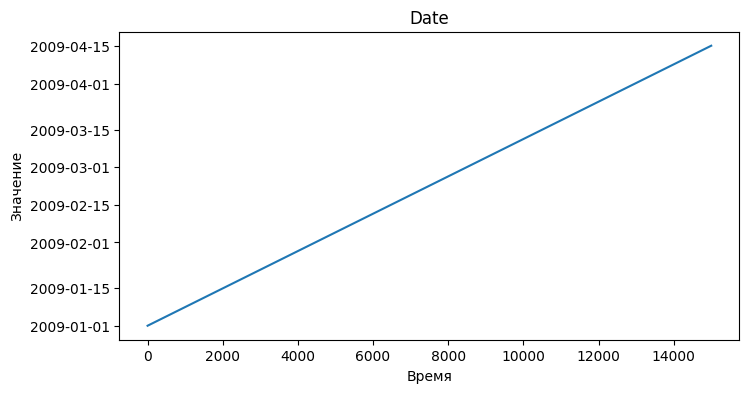

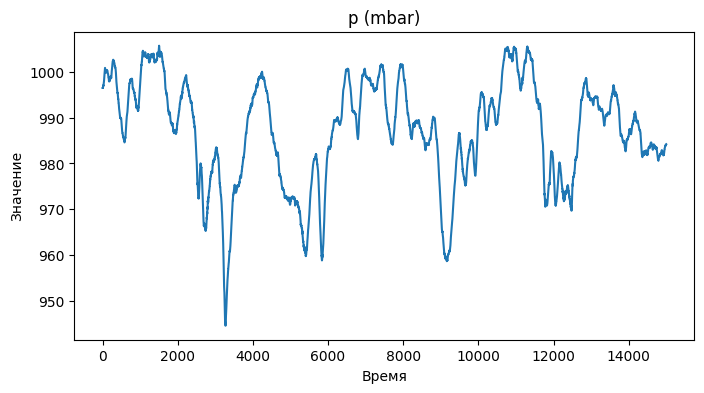

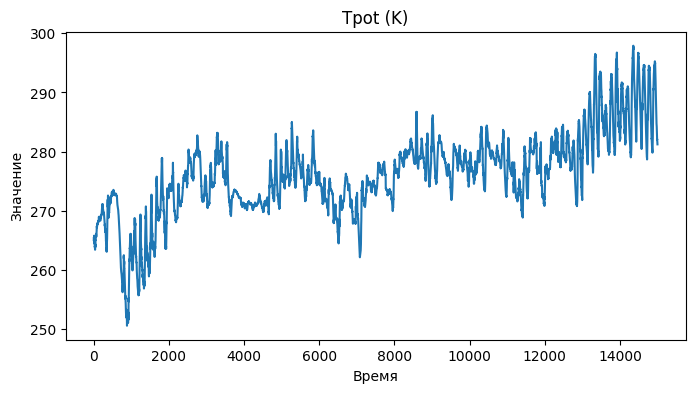

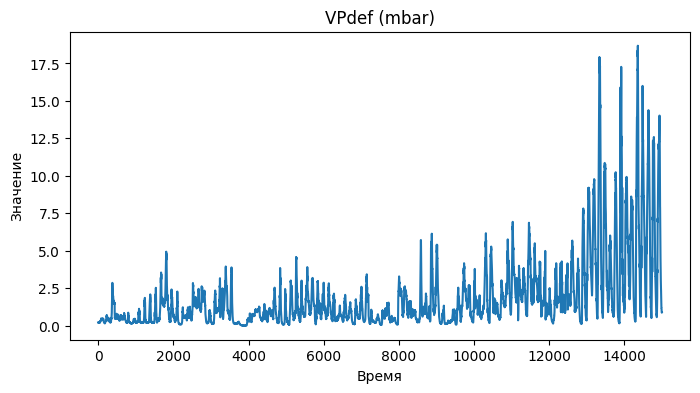

In [81]:
import matplotlib.pyplot as plt
columns = df.columns
for column in columns:
        plt.figure(figsize=(8, 4))
        plt.plot(df[column])
        plt.title(column)
        plt.xlabel('Время')
        plt.ylabel('Значение')
        plt.show()

In [82]:
time_diff = df['Date'].diff()
time_diff.unique()

<TimedeltaArray>
[NaT, '0 days 00:10:00']
Length: 2, dtype: timedelta64[ns]

Посмотрим на составляющие временного ряда

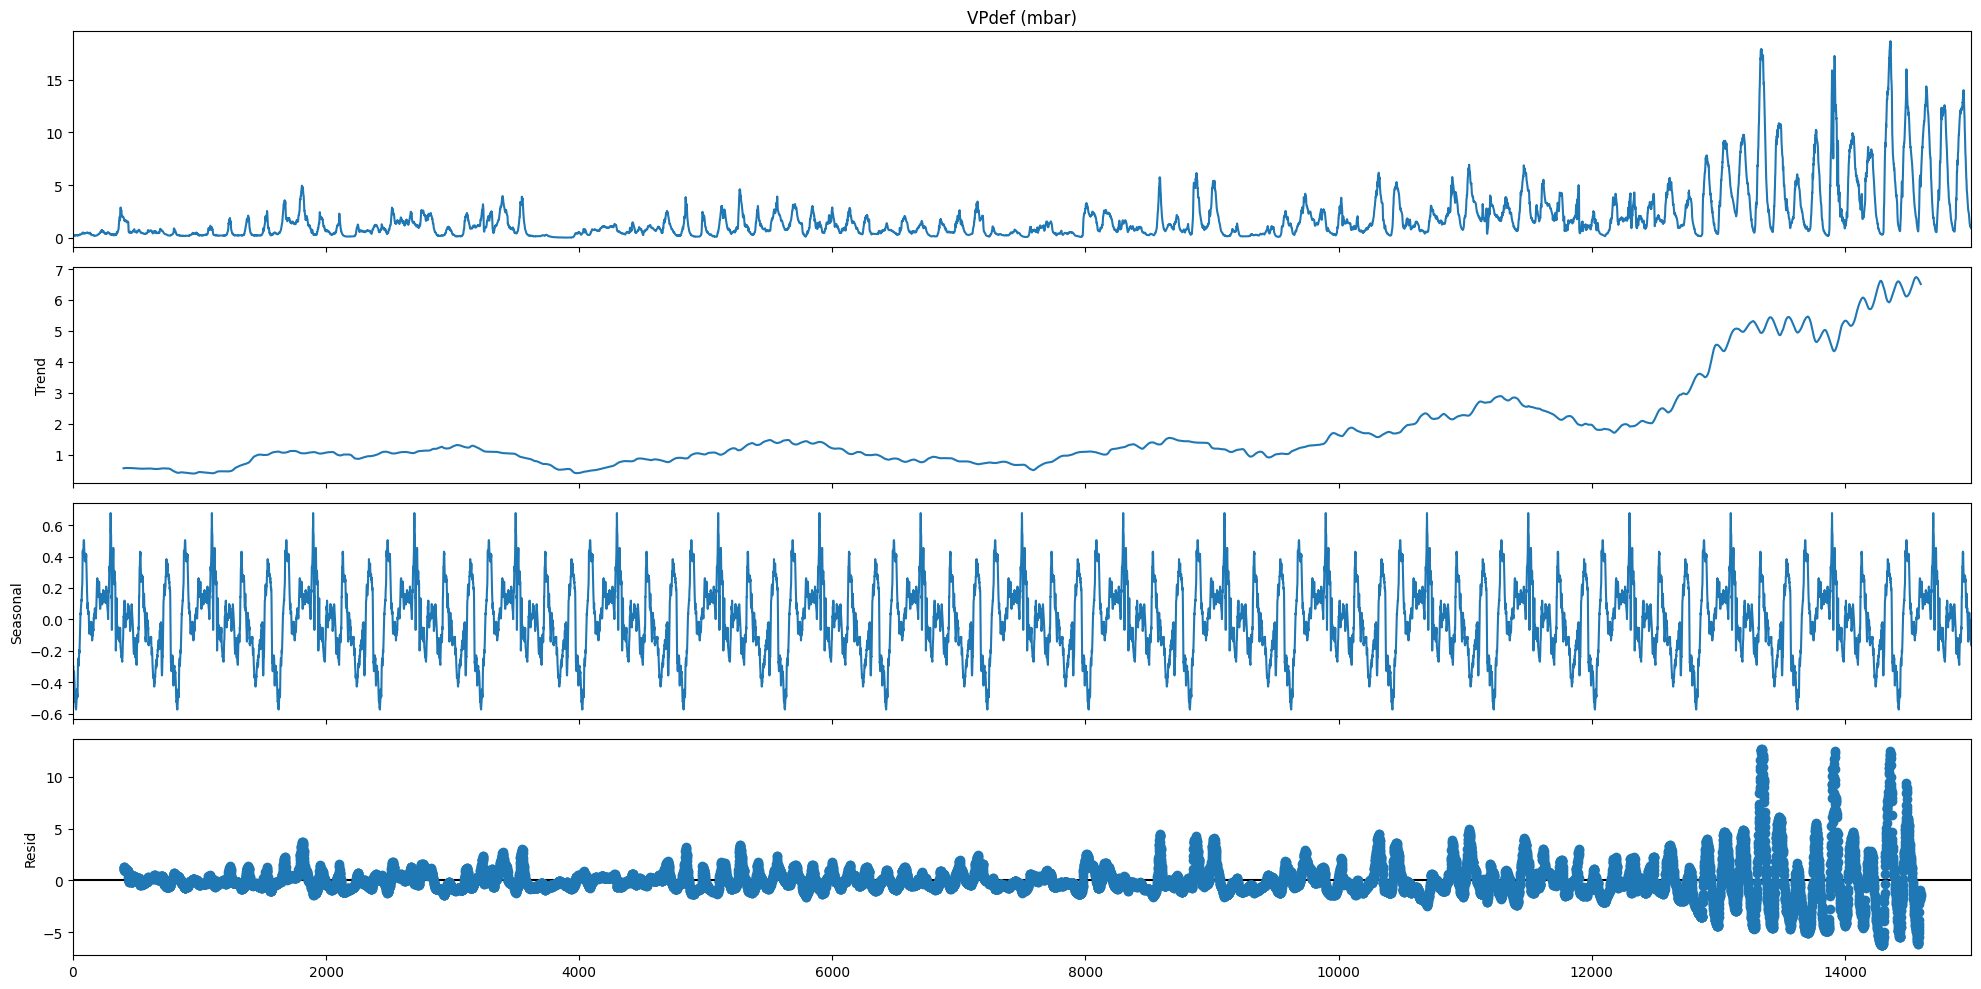

In [83]:
from matplotlib import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose

rcParams['figure.figsize'] = 20, 10
decompose = seasonal_decompose(df['VPdef (mbar)'], period=800)
decompose.plot()
plt.show()

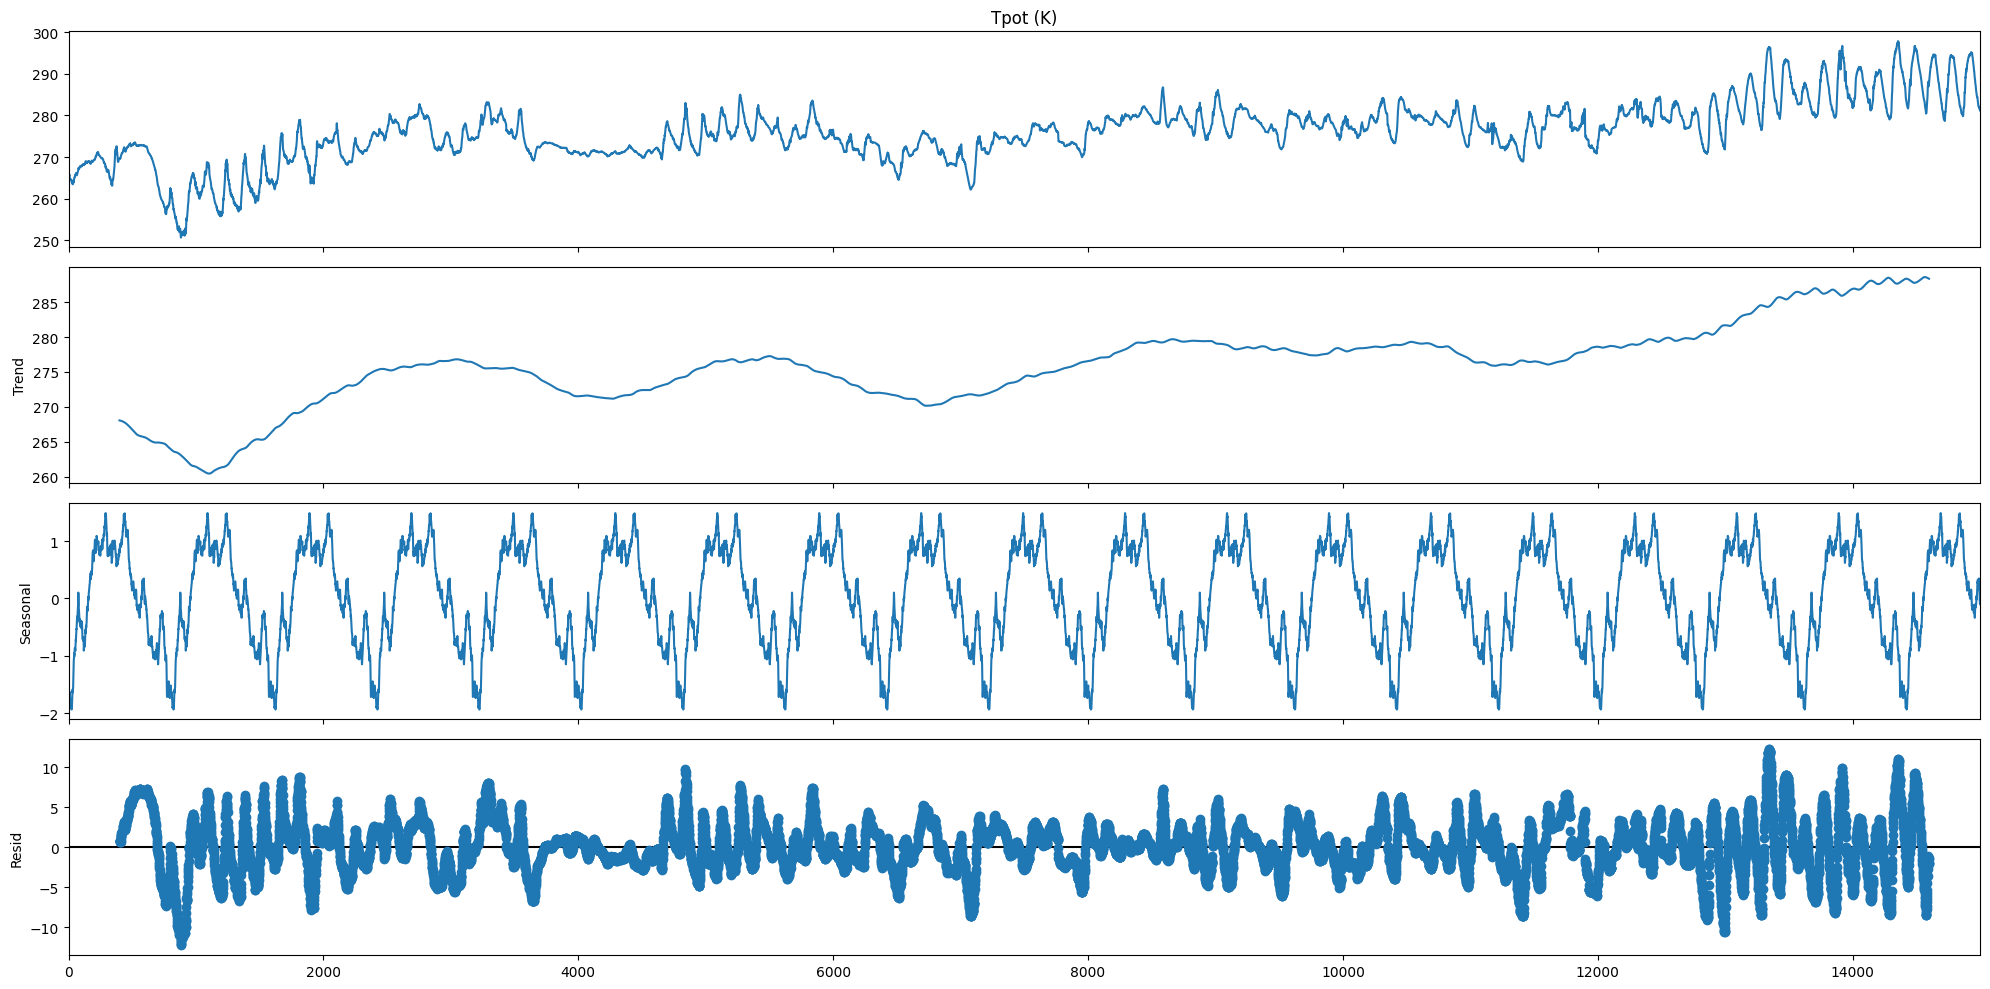

In [84]:
decompose = seasonal_decompose(df['Tpot (K)'], period=800)
decompose.plot()
plt.show()

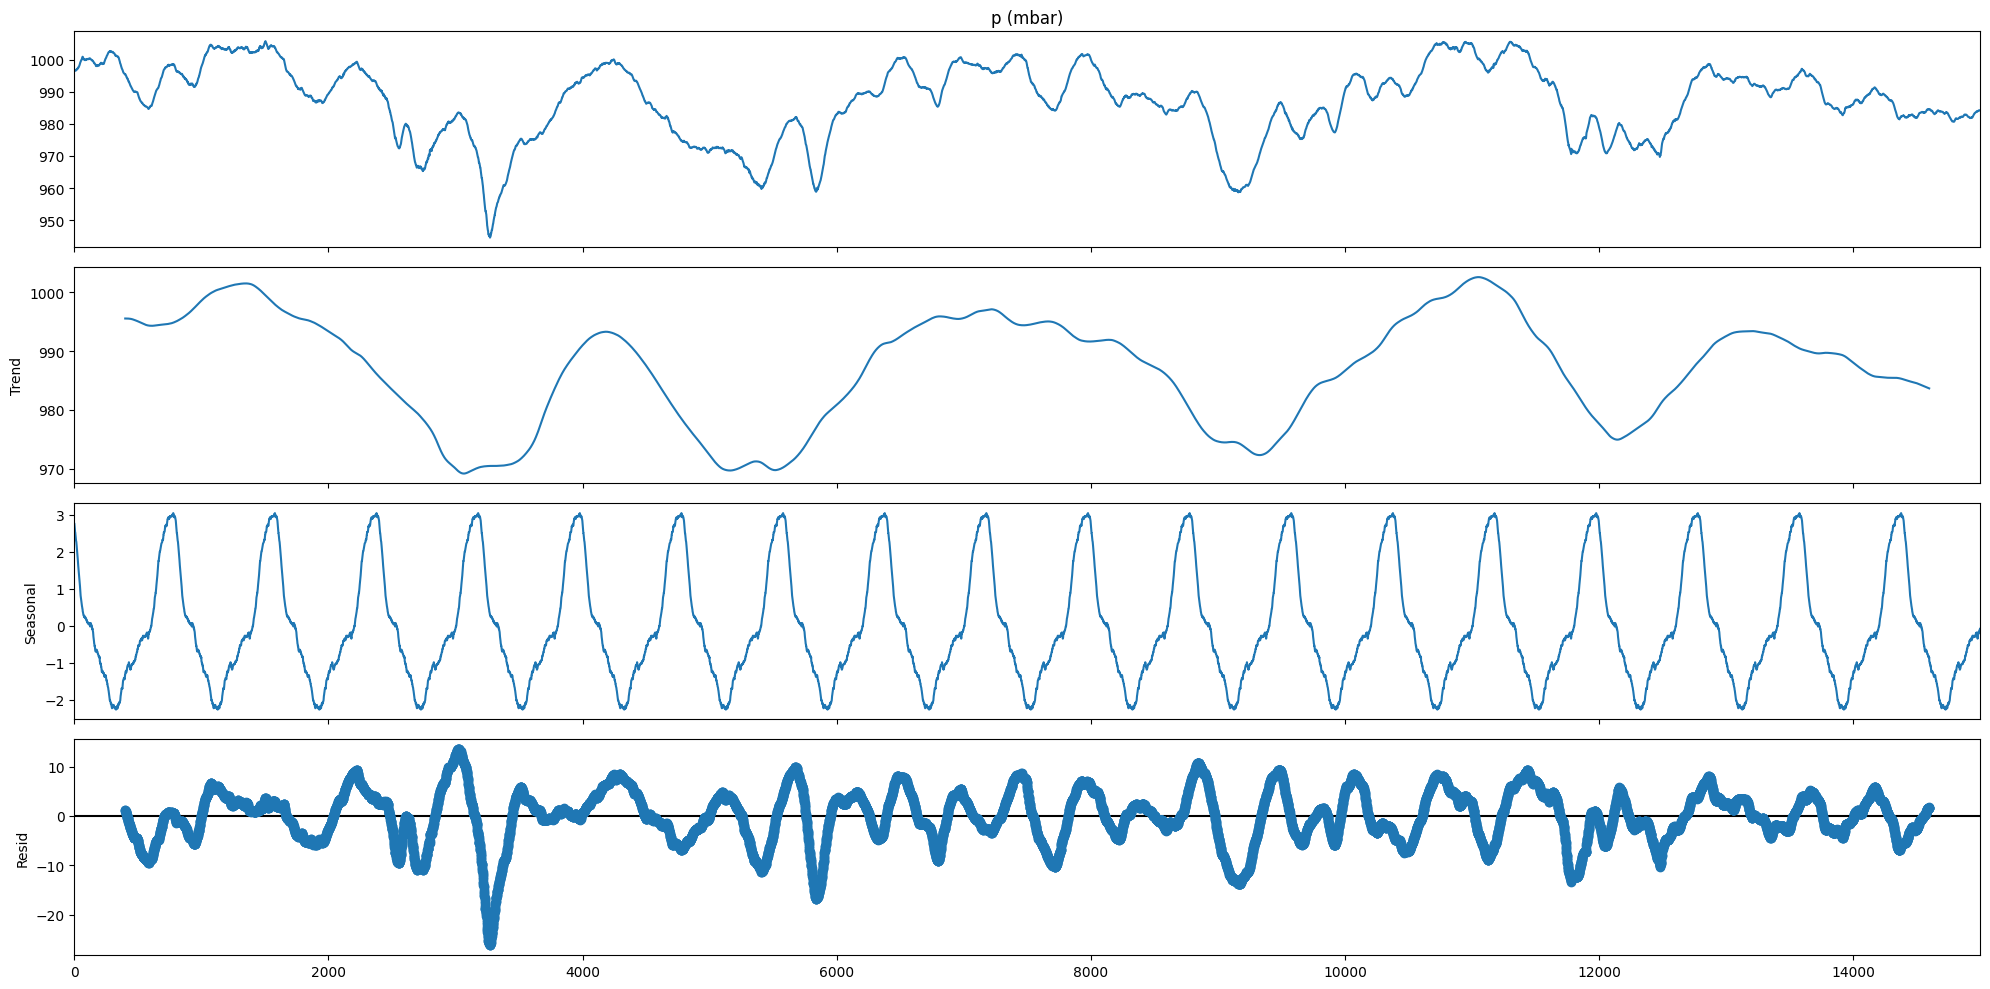

In [85]:
decompose = seasonal_decompose(df['p (mbar)'], period=800)
decompose.plot()
plt.show()

Тренд отсутсвует, наблюдается сезонность

In [86]:
from statsmodels.tsa.stattools import adfuller
def df_test(name: str, df: pd.Series) -> None:
    alpha = 0.05
    name = name
    ts = df
    print(f"Тест Дики-Фуллера ряда {name}:")
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Users', 'Number of Observations Used'])

    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    if dfoutput["p-value"] < alpha:
        print(f"Значение p меньше {alpha*100}%. Ряд стационарный.")
    else:
        print(f"Значение p больше {alpha*100}%. Ряд не стационарный.")

In [87]:
for col in df.columns:
    if col != 'Date/Time':
        df_test(col, df[col])

Тест Дики-Фуллера ряда Date:
Test Statistic                    -0.015012
p-value                            0.957273
#Lags Users                       36.000000
Number of Observations Used    14963.000000
Critical Value (1%)               -3.430787
Critical Value (5%)               -2.861733
Critical Value (10%)              -2.566873
dtype: float64
Значение p больше 5.0%. Ряд не стационарный.
Тест Дики-Фуллера ряда p (mbar):
Test Statistic                    -4.307869
p-value                            0.000430
#Lags Users                       22.000000
Number of Observations Used    14977.000000
Critical Value (1%)               -3.430787
Critical Value (5%)               -2.861733
Critical Value (10%)              -2.566873
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.
Тест Дики-Фуллера ряда Tpot (K):
Test Statistic                    -5.545978
p-value                            0.000002
#Lags Users                       42.000000
Number of Observations Used    14957.000

В моделях VAR и VARMA стационарность данных является важным условием для точного прогнозирования, тогда как для нейронных сетей это необязательно.

Коинтеграция

Коинтеграция временных рядов – причинно-следственная зависимость в уровнях двух и более временных рядов, которая выражается в совпадении или противоположной направленности тенденций данных рядов и случайной колеблемости.

Если временные ряды коинтегрированы, это обычно означает, что можно строить модели, учитывающие их долгосрочные взаимосвязи для лучших предсказаний (VAR, VARMA и т.д.).

In [88]:
from itertools import combinations
from statsmodels.tsa.stattools import coint

del df['Date']
pairs = combinations(df.columns, 2)

for pair in pairs:
    pair_data = df[list(pair)]
    score, pvalue, _ = coint(pair_data[pair[0]], pair_data[pair[1]])

    if pvalue < 0.05:
        print(f"Есть коинтеграция между {pair[0]} и {pair[1]}")
    else:
        print(f"Отсутствует коинтеграция между {pair[0]} и {pair[1]}")

Есть коинтеграция между p (mbar) и Tpot (K)
Есть коинтеграция между p (mbar) и VPdef (mbar)
Есть коинтеграция между Tpot (K) и VPdef (mbar)


Причинность рядов по Грейнджеру - это статистический тест, который используется для определения причинно-следственной связи между двумя временными рядами. Тест Грейнджера позволяет определить, может ли один временной ряд использоваться для прогнозирования другого ряда. Этот подход основан на идее, что если временной ряд X вызывает изменения в другом ряду Y, то значения X должны предшествовать значениям Y

In [101]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

def grangers_causation_matrix(data, variables, test='ssr_chi2test', maxlag=12):
    data_granger = pd.DataFrame(0, columns=variables, index=variables)
    
    for var in variables:
        for var2 in variables:
            results = grangercausalitytests(data[[var, var2]], maxlag=maxlag, verbose=False)
            p_values = [round(results[i+1][0][test][1], 4) for i in range(maxlag)]
            data_granger.loc[var, var2] = np.min(p_values)
    return data_granger


grangers_causation_matrix(df,variables=df.columns)

c:\Users\naida\Desktop\ML PSU\.venv\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\naida\Desktop\ML PSU\.venv\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\naida\Desktop\ML PSU\.venv\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\naida\Desktop\ML PSU\.venv\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\naida\Desktop\ML PSU\.venv\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\naida\Desktop\ML PSU\.venv\lib\site-packages\statsmodels\tsa\stattools.

,p (mbar),Tpot (K),VPdef (mbar)
p (mbar),1,0,0
Tpot (K),0,1,0
VPdef (mbar),0,0,1


Если значение p-уровня значимости, полученное в результате теста Грейнджера, близко к нулю или строго равно нулю (< 0.05) для пары временных рядов, это обычно рассматривается как сильное статистическое подтверждение наличия причинной связи между этими рядами. Такие результаты свидетельствуют о том, что изменения в одном временном ряде действительно влияют на изменения в другом ряде, что делает VAR модели более подходящими для моделирования таких взаимосвязей

Прогнозирование временного ряда методами классик мл

Модель VAR (Vector AutoRegression) - это статистическая модель временных рядов, предназначенная для прогнозирования изменений в нескольких взаимосвязанных переменных в течение времени. Она представляет собой многомерное расширение модели авторегрессии (AR).

VAR моделирует каждую переменную как линейную комбинацию ее предыдущих значений и предыдущих значений других переменных. Это позволяет улучшить прогнозы путем учета взаимосвязей между переменными.

В начале анализа мы можем подобрать оптимальный порядок модели, используя информационные критерии, такие как AIC (Критерий информационной акайке), BIC (Байесовский информационный критерий), FPE (Финальная ошибка прогнозирования) и HQC (Критерий Ханнана-Квинна). Меньшие значения этих критериев указывают на более подходящую модель, и их можно использовать для выбора оптимального порядка модели VAR.

In [102]:
from statsmodels.tsa.vector_ar.var_model import VAR
train, test = df[:10000], df[10000:]

model = VAR(train)

orders = [2, 6, 12, 20, 24, 30, 40, 48, 50, 96, 168, 252, 336]
criteria = ['aic', 'bic', 'fpe', 'hqic']

best_order = {}
best_values = {}
for crit in criteria:
    best_order[crit] = None
    best_values[crit] = np.inf

for i in orders:
    result = model.fit(i)
    for crit in criteria:
        value = getattr(result, crit)
        if value < best_values[crit]:
            best_values[crit] = value
            best_order[crit] = i

for crit in criteria:
    print(f'Optimal lag order chosen by {crit}: {best_order[crit]}, {crit} value: {best_values[crit]}')


Optimal lag order chosen by aic: 20, aic value: -15.160861350925277
Optimal lag order chosen by bic: 12, bic value: -15.072111245505512
Optimal lag order chosen by fpe: 20, fpe value: 2.604484473415569e-07
Optimal lag order chosen by hqic: 12, hqic value: -15.125107930883882


Обучаем модель с наилучшим порядком (20 или 12)

In [103]:
model_fitted = model.fit(12)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 11, Jan, 2024
Time:                     18:14:42
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -15.0721
Nobs:                     9988.00    HQIC:                  -15.1251
Log likelihood:           33264.2    FPE:                2.62706e-07
AIC:                     -15.1522    Det(Omega_mle):     2.59808e-07
--------------------------------------------------------------------
Results for equation p (mbar)
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    0.168463         0.113093            1.490           0.136
L1.p (mbar)              1.373261         0.010049          136.656           0.000
L1.Tpot (K)             -0.014779         0.0

Теперь мы подготовим данные для проведения тестов и выполнения предсказаний.

In [104]:
def create_dataset(data, in_seq_order, for_len=1, step=1):
    X = []
    Y = []
    for i in range(0, len(data) - for_len - in_seq_order, step):
        X.append(data[i:(i+in_seq_order)].to_numpy())
        Y.append(data[(i+in_seq_order):(i+in_seq_order+for_len)].to_numpy())
    return X, Y


In [105]:
X_test, Y_test = create_dataset(test, 12)
X_train, Y_train = create_dataset(train, 12)

In [106]:
Y_pred = []

for i in X_test:
    Y_pred.append(model_fitted.forecast(y=i,steps=1))

In [107]:
Y_pred = np.array(Y_pred)
Y_test = np.array(Y_test)
Y_train = np.array(Y_train)

In [115]:
from numpy import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


def smape_score(y_true, y_pred):
    return round(np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true)) + np.abs(y_pred)) / 2), 3)

def validate(name,true, pred):
    print(f"Метрики {name}")
    print("MSE:", mean_squared_error(true, pred))
    print("RMSE:", sqrt(mean_squared_error(true, pred)))
    print("MAE:", mean_absolute_error(true, pred))
    print("SMAPE:", smape_score(true, pred))
    print("R2:", r2_score(true, pred),"\n")

def plot_and_metrics(columns_name, true, pred, train):
    for n in range(len(columns_name)):
        name = columns_name[n]
        Y_true = true[:, :, n]
        Y_pred = pred[:, :, n]
        Y_train = train[:, :, n]

        plt.figure(figsize=(8, 6))
        plt.plot(Y_train, label='Train')
        plt.plot(range(len(Y_train), len(Y_test) + len(Y_train)), Y_true, label='True')
        plt.plot(range(len(Y_train), len(Y_test) + len(Y_train)), Y_pred, label='Predicted')
        plt.title(f"{name} - True vs Predicted")
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.legend()
        plt.show()

        validate(name, Y_true, Y_pred)

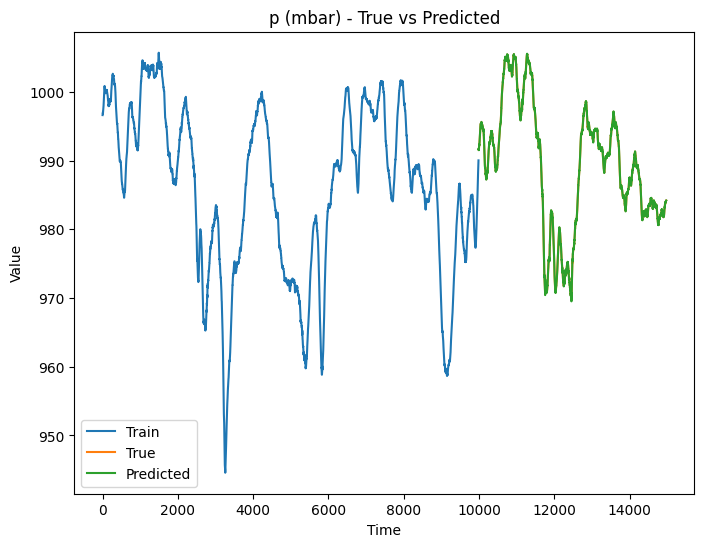

Метрики p (mbar)
MSE: 0.004935551261705595
RMSE: 0.07025347864487277
MAE: 0.04807429497836636
SMAPE: 0.0
R2: 0.9999398491318355 



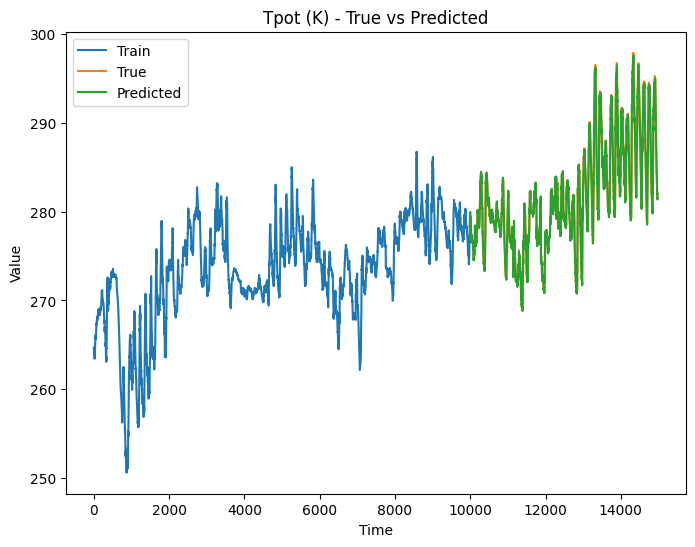

Метрики Tpot (K)
MSE: 0.05493019845219637
RMSE: 0.23437192334449186
MAE: 0.1496059150097048
SMAPE: 0.0
R2: 0.9984723047591227 



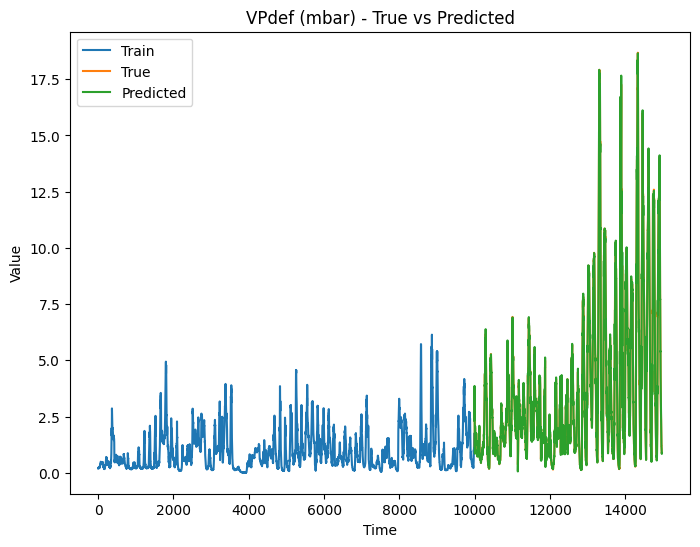

Метрики VPdef (mbar)
MSE: 0.042287088208831564
RMSE: 0.2056382459778131
MAE: 0.10704504013538109
SMAPE: 0.009
R2: 0.9964390650597262 



In [116]:
plot_and_metrics(df.columns, Y_test, Y_pred, Y_train)

Метрики демонстрируют хорошую качества модели: значение MSE, RMSE и MAE ниже 1, что является приемлемым, а иногда и приближается к 0. SMAPE также хорошо себя показывает, приближаясь к нулю, что является идеальным результатом. Значение R2 около 0.99, подтверждая высокую точность модели, приближаясь к единице, что отлично.

VARMA (Vector AutoRegressive Moving-Average) - это модель, применяемая в анализе временных рядов для описания взаимозависимостей между несколькими временными рядами. В контексте VARMA, каждый временной ряд в системе рассматривается как комбинация своих предыдущих значений (авторегрессия) и лагированных ошибок прогнозирования (скользящая средняя). Важно отметить, что VARMA представляет собой обобщение модели ARMA, расширяя её на случай многомерных данных.

В модели ARMA (AutoRegressive Moving Average), каждый временной ряд моделируется на основе его собственных предыдущих значений (авторегрессионный компонент) и предыдущих ошибок прогнозирования (скользящая средняя компонент).

Таким образом, VARMA предполагает, что изменения в одном временном ряде могут влиять на изменения в другом временном ряде, и наоборот. Эта модель часто используется для анализа и прогнозирования временных рядов, когда взаимодействие между переменными играет ключевую роль. Это как раз наш случай

In [ ]:
X = df
train, test = X[:10000], X[10000:]

In [120]:
pip install joblib #для паралельной работы


SyntaxError: invalid syntax. Perhaps you forgot a comma? (1286675876.py, line 1)

In [122]:
from pmdarima import auto_arima
from joblib import Parallel, delayed

def find_order(name, data):
    print(f'Searching order of p and q for : {name}')
    stepwise_model = auto_arima(data, start_p=1, start_q=1, max_p=7, max_q=7, seasonal=False,
                                trace=True, error_action='ignore', suppress_warnings=True, stepwise=True, maxiter=1000)
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    return parameter

pq = Parallel(n_jobs=-1)(delayed(find_order)(name, column) for name, column in df.items())



In [123]:
pq

[(4, 1, 1), (7, 1, 1), (4, 1, 0)]

Подберем наилучший порядок

In [131]:
df_results_moni = pd.DataFrame(columns=['p', 'q', 'RMSE p (mbar)', 'RMSE Tpot (K)', 'RMSE VPdef (mbar)'])
results_list = []

for i in pq:
    if i[0] == 0 and i[2] == 0:
        pass
    else:
        model = VARMAX(train, order=(i[0], 0, i[2])).fit(disp=False)
        result = model.forecast(steps=len(test))
        
        rmse_p = np.sqrt(metrics.mean_squared_error(test['p (mbar)'], result['p (mbar)']))
        rmse_tpot = np.sqrt(metrics.mean_squared_error(test['Tpot (K)'], result['Tpot (K)']))
        rmse_vpdef = np.sqrt(metrics.mean_squared_error(test['VPdef (mbar)'], result['VPdef (mbar)']))
        
        results_list.append({'p': i[0], 'q': i[2], 'RMSE p (mbar)': rmse_p, 'RMSE Tpot (K)': rmse_tpot, 'RMSE VPdef (mbar)': rmse_vpdef})

df_results_moni = pd.DataFrame(results_list)


In [132]:
df_results_moni.sort_values(by = ['RMSE p (mbar)', 'RMSE Tpot (K)', 'RMSE VPdef (mbar)'] )

,p,q,RMSE p (mbar),RMSE Tpot (K),RMSE VPdef (mbar)
1,7,1,8.656614,10.325722,4.368732
0,4,1,8.703049,10.311515,4.370135
2,4,0,8.703049,10.311515,4.370135


Наилучшие p, q - 7,1

In [134]:
model = VARMAX(train, order=(7,1)).fit(disp=False)
result = model.forecast(steps=len(test))
result

c:\Users\naida\Desktop\ML PSU\.venv\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


,p (mbar),Tpot (K),VPdef (mbar)
10000,990.345617,278.066381,1.887239
10001,990.477912,278.101482,1.929597
10002,990.601652,278.153355,1.974253
10003,990.717624,278.211874,2.020301
10004,990.834766,278.252760,2.060852
...,...,...,...
14995,986.023298,273.270566,0.951896
14996,986.023272,273.270574,0.951896
14997,986.023246,273.270582,0.951896
14998,986.023221,273.270589,0.951897


Посчитаем метрики и выведем предсказания

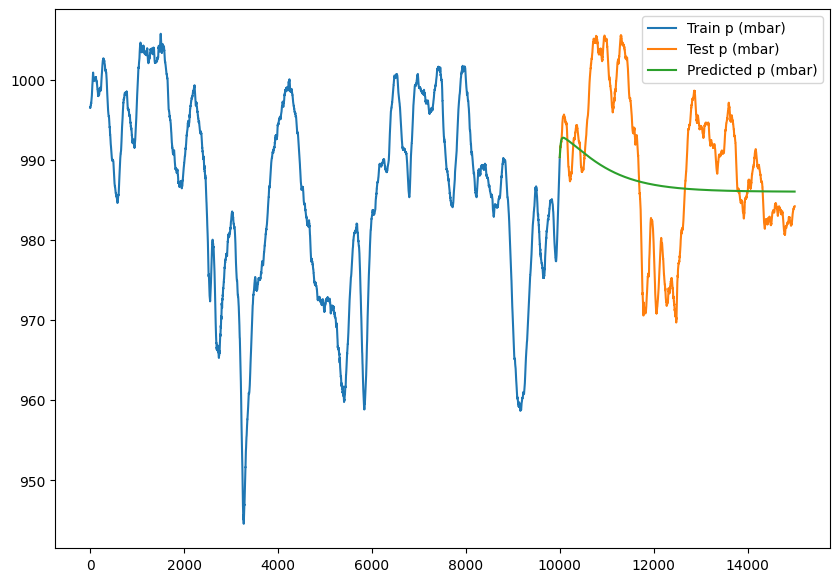

Evaluation metric for p (mbar) Metrics:
MSE: 74.93878653561839
MAE: 7.107915216968764
RMSE: 8.656719155408611
SMAPE: 0.002
R2: 0.08446260518893367



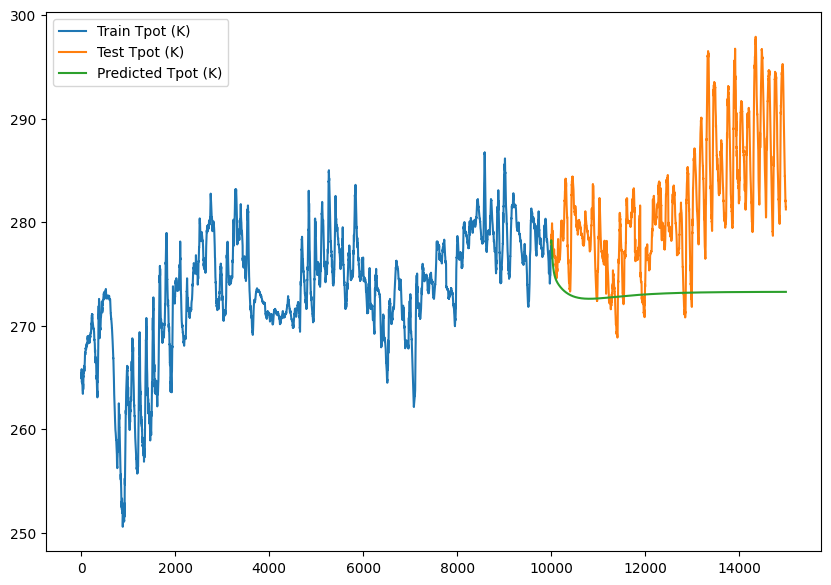

Evaluation metric for Tpot (K) Metrics:
MSE: 106.61814243646373
MAE: 8.59087037932353
RMSE: 10.32560615346449
SMAPE: 0.008
R2: -1.9707523976036927



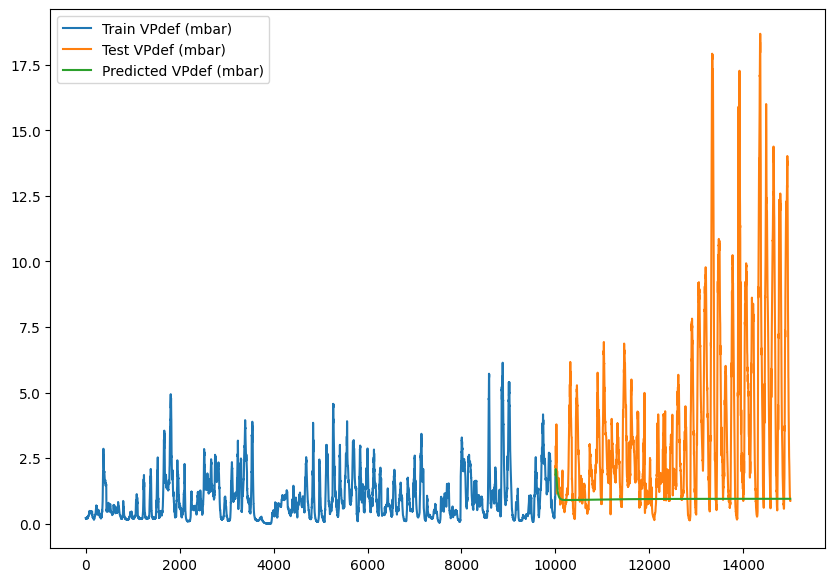

Evaluation metric for VPdef (mbar) Metrics:
MSE: 19.085801888755658
MAE: 2.8057446311132757
RMSE: 4.36873000868166
SMAPE: 0.229
R2: -0.6106438327294064



In [136]:
def smape_score(y_true, y_pred):
    return round(np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true)) + np.abs(y_pred)) / 2), 3)

def timeseries_evaluation_metrics_func(y_true, y_pred, metric_name):
    mse = metrics.mean_squared_error(y_true, y_pred)
    mae = metrics.mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    smape = smape_score(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)

    print(f'{metric_name} Metrics:')
    print(f'MSE: {mse}')
    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')
    print(f'SMAPE: {smape}')
    print(f'R2: {r2}\n')

columns_to_plot = ['p (mbar)', 'Tpot (K)', 'VPdef (mbar)']

for column in columns_to_plot:
    plt.rcParams["figure.figsize"] = [10, 7]
    plt.plot(train[column], label=f'Train {column}')
    plt.plot(range(10000, 15000), test[column], label=f'Test {column}')
    plt.plot(range(10000, 15000), result[column], label=f'Predicted {column}')
    plt.legend(loc='best')
    plt.show()

    timeseries_evaluation_metrics_func(test[column], result[column], f'Evaluation metric for {column}')



Анализ метрик для каждого временного ряда:

p (mbar):
MSE и RMSE удовлетворительны, указывая на низкую среднеквадратичную ошибку предсказаний.
MAE показывает хороший результат, означая малую среднюю абсолютную ошибку.
SMAPE имеет невысокое значение, что также указывает на неплохую симметричность процентного отклонения.
Однако, R2 отрицателен, что может сигнализировать о том, что модель плохо объясняет изменения в данном временном ряде.

Tpot (K):
MSE и RMSE оставляют желать лучшего, указывая на более высокую среднеквадратичную ошибку.
MAE показывает неплохой, но не идеальный результат.
SMAPE имеет более высокое значение, что может сигнализировать о более значительном процентном отклонении.
Очень низкое значение R2 указывает на то, что модель практически не объясняет изменения в этом ряде.

VPdef (mbar):
MSE и RMSE умеренны, указывая на среднюю среднеквадратичную ошибку.
MAE дает хороший результат с низкой средней абсолютной ошибкой.
Высокое значение SMAPE может указывать на существенное процентное отклонение.
Отрицательное значение R2 говорит о том, что модель не лучше, чем простое среднее.

В целом, метрики показывают относительно удовлетворительные результаты, но существует некоторое пространство для улучшения. Обратите внимание на отрицательные значения R2, что может свидетельствовать о недостаточной способности модели объяснить изменения в данных. Возможно, стоит рассмотреть дополнительные методы улучшения модели или дополнительную настройку параметров.